Sample of the simulated IoT dataset:
   soil_moisture  temperature   humidity   rainfall    sunlight      yield
0      42.472407    28.963234  49.256646  10.381636  357.023410  60.057659
1      77.042858    25.721927  67.095047   9.583638  348.187279  85.767376
2      63.919637    21.190552  83.647292   0.512841  743.752748  96.955266
3      55.919509    31.275900  76.611244   6.824957  349.727720  67.034583
4      29.361118    28.694623  80.328057   7.603912  363.169836  55.049950


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Evaluation:
Mean Absolute Error (MAE): 9.85 kg/ha


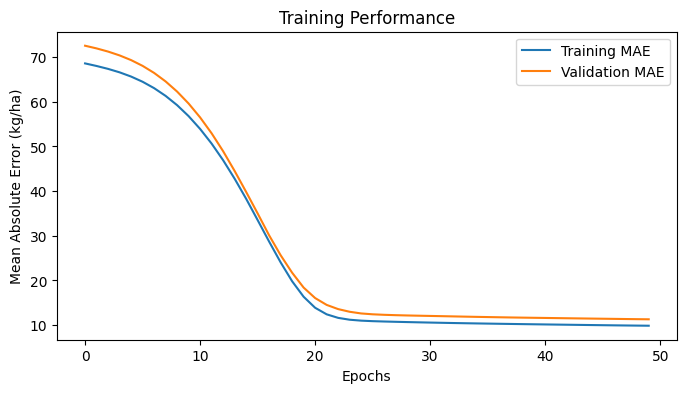

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Predicted Crop Yield for current conditions: 59.70 kg/ha
Saved artifact at '/tmp/tmppq81kkj4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138185659425104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138185659426256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138188064592464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138185659424144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138185659426832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138185659423760: TensorSpec(shape=(), dtype=tf.resource, name=None)

✅ Model converted to TensorFlow Lite format (smart_agri_yield_model.tflite)


In [1]:
# ============================================
# SMART AGRICULTURE SIMULATION SYSTEM
# AI + IoT Concept Demonstration
# ============================================

# Step 1: Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# Step 2: Simulate IoT Sensor Data
# ============================================

# Number of samples (e.g., 500 days of readings)
n_samples = 500

# Generate simulated sensor readings
data = {
    "soil_moisture": np.random.uniform(20, 80, n_samples),   # in percentage
    "temperature": np.random.uniform(15, 35, n_samples),     # °C
    "humidity": np.random.uniform(40, 90, n_samples),        # %
    "rainfall": np.random.uniform(0, 20, n_samples),         # mm/day
    "sunlight": np.random.uniform(200, 800, n_samples),      # lux (simulated)
}

df = pd.DataFrame(data)

# Simulated crop yield (in kg/ha)
# Assume soil moisture, sunlight, and rainfall positively impact yield
# while extreme temperature reduces it
df["yield"] = (
    0.5 * df["soil_moisture"]
    + 0.3 * df["humidity"]
    + 0.4 * df["rainfall"]
    + 0.05 * df["sunlight"]
    - 0.8 * np.abs(df["temperature"] - 25)
    + np.random.normal(0, 10, n_samples)  # noise
)

print("Sample of the simulated IoT dataset:")
print(df.head())

# ============================================
# Step 3: Split the Data (Train/Test)
# ============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[["soil_moisture", "temperature", "humidity", "rainfall", "sunlight"]]
y = df["yield"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ============================================
# Step 4: Build a Simple Neural Network Model
# ============================================

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output (predicted yield)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ============================================
# Step 5: Train the Model
# ============================================
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)

# ============================================
# Step 6: Evaluate the Model
# ============================================
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nModel Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.2f} kg/ha")

# Plot training performance
plt.figure(figsize=(8,4))
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (kg/ha)")
plt.legend()
plt.show()

# ============================================
# Step 7: Example Prediction (Simulated IoT Input)
# ============================================
sample_input = np.array([[55, 27, 70, 5, 600]])  # hypothetical new readings
sample_input_scaled = scaler.transform(sample_input)
predicted_yield = model.predict(sample_input_scaled)
print(f"\nPredicted Crop Yield for current conditions: {predicted_yield[0][0]:.2f} kg/ha")

# ============================================
# Step 8: Convert Model to TensorFlow Lite (Edge Deployment)
# ============================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("smart_agri_yield_model.tflite", "wb") as f:
    f.write(tflite_model)

print("\n✅ Model converted to TensorFlow Lite format (smart_agri_yield_model.tflite)")
